In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings("ignore")

In [2]:
basedir = '
datadir = basedir+'Data\\'
modeldir = basedir+'Models\\'
chartdir = basedir+'Charts\\'

In [3]:
data = pd.read_csv(datadir+'Dataset.csv')

# Preprocessing - Cleaning

In [4]:
data.isnull().sum()

likes            0
Checkins         0
Returns         51
Category        57
commBase        60
comm24           0
comm48          48
comm24_1         0
diff_24,48       0
baseTime         0
length           0
shares        2449
hrs              0
sun_pub          0
mon_pub       1927
tue_pub          0
wed_pub          0
thu_pub       3045
fri_pub          0
sat_pub          0
sun_base         0
mon_base      1970
tue_base         0
wed_base         0
thu_base         0
fri_base         0
sat_base         0
output           0
dtype: int64

### Handling the null values for comm48
From the understanding in the description of the data diff_24,48 is difference of comm24 and comm48, CC5 = CC2 - CC3. Hence back tracking it to find the null values of comm48, since comm24 and diff_24,48 has no null values.

In [5]:
data.loc[:,'comm48'] = data['comm24'] - data['diff_24,48']

### Handling the null values in 'Returns', 'Category', 'commBase' and 'shares' Features
For each page, Returns and Category values are same for all posts so maxfrequency value (mode) is replaced in place of null.<br>
For commBase and shares feature's null values are replaced by maxfrequency values (mode) because of the frequency distribution.

In [6]:
unq_likes = data.likes.unique().tolist()
returndict = {}
categorydict = {}
commBasedict = {}
sharesdict = {}
for i in unq_likes:
    try:
        returndict[i] = int(data.loc[data.likes==i,'Returns'].mode()[0])
        categorydict[i] = int(data.loc[data.likes==i,'Category'].mode()[0])
        commBasedict[i] = int(data.loc[data.likes==i,'commBase'].mode()[0])
        sharesdict[i] = int(data.loc[data.likes==i,'shares'].mode()[0])
    except:
        returndict[i] = int(0.0)
        categorydict[i] = int(0.0)
        commBasedict[i] = int(0.0)
        sharesdict[i] = int(0.0)

In [7]:
for i in unq_likes:
    data.loc[data.likes==i,'Returns'] = returndict[i]
    data.loc[data.likes==i,'Category'] = categorydict[i]
    data.loc[data.likes==i,'commBase'] = data.loc[data.likes==i,'commBase'].replace(to_replace = np.nan, value = commBasedict[i])
    data.loc[data.likes==i,'shares'] = data.loc[data.likes==i,'shares'].replace(to_replace = np.nan, value = sharesdict[i])

### Handling null values for basetime weekday features
 Features are 'sun_base', 'mon_base', 'tue_base', 'wed_base', 'thu_base', 'fri_base', 'sat_base'

The data features mentioned above are the one hot encoding of the day of week for which the basetime was taken for prediction. As basetime is given for all posts it is concluded that it should lie on any one of the day. But there is a data collection error that all dummy variables are zero. The problem is handled my making perfect one hot encoding mean while the null values are also handled.<br>
<br>
Logic - if features 'sun_base', 'tue_base', 'wed_base', 'thu_base', 'fri_base', 'sat_base' is 0 then 'mon_base' is 1<br>
        if any one features 'sun_base', 'tue_base', 'wed_base', 'thu_base', 'fri_base', 'sat_base' is 1 then 'mon_base' is 0<br>
This above logic will remove the error and null values.

In [8]:
data.loc[(data.sun_base==0)&(data.tue_base==0)&(data.wed_base==0)&(data.thu_base==0)&(data.fri_base==0)&(data.sat_base==0) ,'mon_base'] = 1
data.loc[(data.sun_base==1)|(data.tue_base==1)|(data.wed_base==1)|(data.thu_base==1)|(data.fri_base==1)|(data.sat_base==1) ,'mon_base'] = 0

### Handling null values for publishingtime weekday features
 Features are 'sun_pub', 'mon_pub', 'tue_pub', 'wed_pub', 'thu_pub', 'fri_pub', 'sat_pub'

The data features mentioned above are the one hot encoding of the day of week for which the post was published. Having that the post is published on any one of the day, the problem is handled my making perfect one hot encoding mean while the part of null values are also handled.<br>
<br>
While handling these null values, both mon_pub and thu_pub sometimes occur null, If any one of the other days except mon_pub and thu_pub is not null the we can replace these two by 0 other than that is dropped and does not greatly affect the whole dataset.
<br>
Logic:<br>
If features 'sun_pub', 'tue_pub', 'wed_pub', 'thu_pub', 'fri_pub', 'sat_pub' is 0 then 'mon_pub' is 1<br>
If any one features 'sun_pub', 'tue_pub', 'wed_pub', 'thu_pub', 'fri_pub', 'sat_pub' is 1 then 'mon_pub' is 0<br>
If features 'sun_pub', 'mon_pub', 'tue_pub', 'wed_pub', 'fri_pub', 'sat_pub' is 0 then 'thu_pub' is 1<br>
If any one features 'sun_pub', 'mon_pub', 'tue_pub', 'wed_pub', 'fri_pub', 'sat_pub' is 1 then 'thu_pub' is 0<br>
This above logic will remove the error and null values.

In [9]:
data.loc[(data.sun_pub==1)|(data.tue_pub==1)|(data.wed_pub==1)|(data.fri_pub==1)|(data.sat_pub==1) ,'mon_pub'] = 0
data.loc[(data.sun_pub==1)|(data.tue_pub==1)|(data.wed_pub==1)|(data.fri_pub==1)|(data.sat_pub==1) ,'thu_pub'] = 0

In [10]:
data = data.drop(index=data.loc[(data.mon_pub.isnull()) & (data.thu_pub.isnull())].index.values)

In [11]:
data.loc[(data.sun_pub==0)&(data.tue_pub==0)&(data.wed_pub==0)&(data.thu_pub==0)&(data.fri_pub==0)&(data.sat_pub==0) ,'mon_pub'] = 1
data.loc[(data.sun_pub==0)&(data.mon_pub==0)&(data.tue_pub==0)&(data.wed_pub==0)&(data.fri_pub==0)&(data.sat_pub==0) ,'thu_pub'] = 1

In [12]:
data.loc[(data.sun_pub==1)|(data.tue_pub==1)|(data.wed_pub==1)|(data.thu_pub==1)|(data.fri_pub==1)|(data.sat_pub==1) ,'mon_pub'] = 0
data.loc[(data.sun_pub==1)|(data.mon_pub==1)|(data.tue_pub==1)|(data.wed_pub==1)|(data.fri_pub==1)|(data.sat_pub==1) ,'thu_pub'] = 0

In [13]:
data.isnull().sum()

likes         0
Checkins      0
Returns       0
Category      0
commBase      0
comm24        0
comm48        0
comm24_1      0
diff_24,48    0
baseTime      0
length        0
shares        0
hrs           0
sun_pub       0
mon_pub       0
tue_pub       0
wed_pub       0
thu_pub       0
fri_pub       0
sat_pub       0
sun_base      0
mon_base      0
tue_base      0
wed_base      0
thu_base      0
fri_base      0
sat_base      0
output        0
dtype: int64

__Resetting index and converting datatype to int64__

In [14]:
data = data.astype(np.int64)
data = data.reset_index(drop=True)

__Exporting the Clean Null Handled data__

In [15]:
data.to_csv(datadir+'cleanedDATA.csv')

### Droping the Extra Dummy Variables

For each level of N categorical variable in a features takes N-1 dummy variables. 

In the Publishingtime weekday features, sun_pub is dropped.<br>
It is taken that mon_pub, tue_pub, wed_pub, thu_pub, fri_pub, sat_pub is 0 then sun_pub is 1.<br>
<br>
In the basetime weekday features, sun_base is dropped.<br>
It is taken that mon_base, tue_base, wed_base, thu_base, fri_base, sat_base is 0 then sun_base is 1.<br>
<br>

In [16]:
data = data.drop(columns=['sun_pub','sun_base'])

In [17]:
columns = data.columns.tolist()

In [18]:
dim = data.shape
print('Records:',dim[0])
print('Features:',dim[1])

Records: 40526
Features: 26


# Feature Selection

### Correlation

In [19]:
corr = data.corr()

__Features with good Positive Relationship with Output__<br>

In [20]:
pcorrf = pd.DataFrame(corr.output[(data.corr().output>0.1) & (data.corr().output<1)].sort_values(ascending=False))
pcorrf

,output
comm24,0.521875
"diff_24,48",0.372233
comm24_1,0.336864
commBase,0.322349
Returns,0.174994
shares,0.139432


__Features with good Negative Relationship with Output__

In [21]:
ncorrf = pd.DataFrame(corr.output[(data.corr().output>-1) & (data.corr().output<-0.1)].sort_values(ascending=False))
ncorrf

,output
baseTime,-0.221868


__Multicolinearity of features__

In [22]:
mcorr = corr.iloc[0:-1,0:-1]
mcorrf = mcorr[(mcorr>0.7) & (mcorr<1)|(mcorr<-0.7) & (mcorr>-1)].dropna(axis=0,how='all').dropna(axis=1,how='all')
mcorrf

,commBase,comm48,comm24_1
commBase,NaN,0.712877,0.996691
comm48,0.712877,NaN,NaN
comm24_1,0.996691,NaN,NaN


Selected Features from Correlation plot<br>
'comm24','diff_24,48','comm24_1','commBase','Returns','shares','baseTime','output'


### Variance Threshold Factor

In [23]:
X = data.loc[:,data.columns!='output']
Y = data.loc[:,data.columns=='output']

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Features"] = X.columns
vif.sort_values('VIF Factor').reset_index(drop=True)

,VIF Factor,Features
0,1.095577,Checkins
1,1.190148,length
2,1.290961,shares
3,1.759396,likes
4,2.048137,mon_base
5,2.188327,sat_base
6,2.232927,sat_pub
7,2.261197,mon_pub
8,2.417232,Returns
9,2.496034,tue_base


We can infer that (commBase and comm24_1) is very highly correlated and (diff_24,48, comm24, comm48) are very highly correlated.

### Recursive Feature Elimination

In [25]:
X = np.array(data.iloc[:,data.columns!='output'])
Y = np.array(data.iloc[:,data.columns=='output']).reshape(-1)

In [26]:
featurestoselect = 15

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
estimator = LinearRegression()
clf = RFE(estimator, n_features_to_select = featurestoselect)
clf.fit(X,Y)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=15, step=1, verbose=0)

In [27]:
print("Freature Ranking by RFE")
[i+' - ' +str(j) for i,j in zip(data.columns.tolist() , clf.ranking_.tolist())]

Freature Ranking by RFE


['likes - 11',
 'Checkins - 9',
 'Returns - 10',
 'Category - 6',
 'commBase - 1',
 'comm24 - 1',
 'comm48 - 1',
 'comm24_1 - 1',
 'diff_24,48 - 1',
 'baseTime - 1',
 'length - 8',
 'shares - 7',
 'hrs - 1',
 'mon_pub - 2',
 'tue_pub - 5',
 'wed_pub - 1',
 'thu_pub - 1',
 'fri_pub - 1',
 'sat_pub - 4',
 'mon_base - 1',
 'tue_base - 1',
 'wed_base - 1',
 'thu_base - 1',
 'fri_base - 1',
 'sat_base - 3']

In [28]:
print("Top {} Selected Features are listed below".format(featurestoselect))
data.columns[:-1][clf.support_].tolist()

Top 15 Selected Features are listed below


['commBase',
 'comm24',
 'comm48',
 'comm24_1',
 'diff_24,48',
 'baseTime',
 'hrs',
 'wed_pub',
 'thu_pub',
 'fri_pub',
 'mon_base',
 'tue_base',
 'wed_base',
 'thu_base',
 'fri_base']

### Conclusion From All Feature Selection Methods

__Top 15 Ranked Features From RFE are:__
- commBase, comm24, comm48, comm24_1, diff_24,48, baseTime, hrs, wed_pub, thu_pub, fri_pub, mon_base, tue_base, wed_base, thu_base, fri_base.

__Assuming the Colinearity from VIF and Correlation plot__<br>
- We can drop commBase feature that reduce correlation with comm48, comm24_1<br>
- We can drop diff_24,48 feature that reduce correlation with comm24, comm48<br>
- We can add Returns and share features since it has some correlation with output.

__Selected Features__ 
- comm24, 
- comm48, 
- comm24_1, 
- baseTime, 
- hrs, 
- wed_pub, 
- thu_pub, 
- fri_pub, 
- mon_base,
- tue_base,
- wed_base,
- thu_base,
- fri_base,
- Returns,
- shares


In [29]:
columns = ['comm24','comm48','comm24_1','baseTime','hrs','wed_pub','thu_pub','fri_pub','mon_base','tue_base','wed_base','thu_base','fri_base','Returns','shares','output']

In [30]:
print("No.of Selected Features with 1 target variable is",len(columns))

No.of Selected Features with 1 target variable is 16


In [31]:
dat = data.copy()

In [32]:
dat = dat.loc[:,columns]

# Feature Transformation

__Log transformation__
- log1p(x) = log(1+x)

In [33]:
dat = np.log1p(dat)

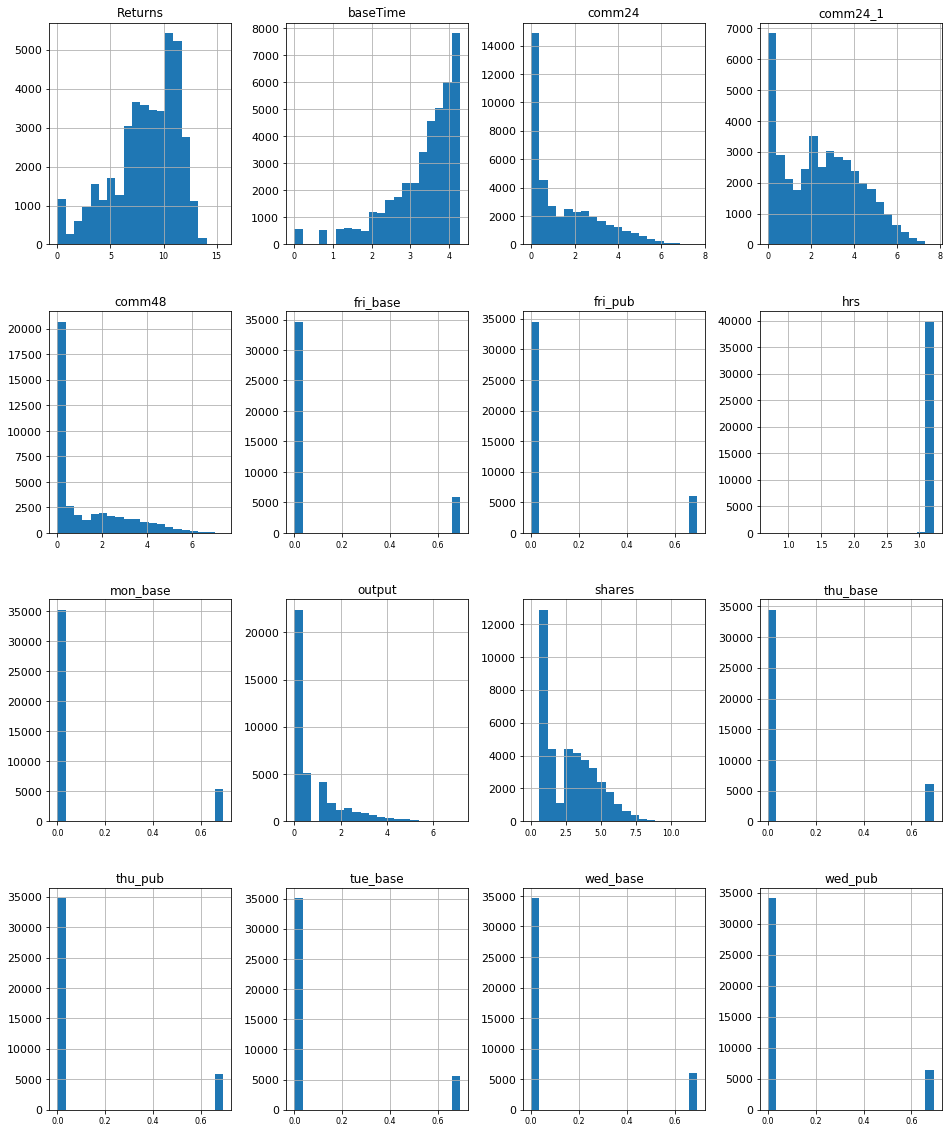

In [34]:
dat.loc[:,columns].hist(figsize=(16,20), bins=20, xlabelsize=8, ylabelsize=11)
plt.savefig(chartdir+'Distribution of Selected Transformed Features.png')
plt.show()

In [35]:
dat.skew()

comm24       0.945662
comm48       1.135183
comm24_1     0.244353
baseTime    -1.436977
hrs        -11.533727
wed_pub      1.863754
thu_pub      2.028544
fri_pub      1.986159
mon_base     2.163486
tue_base     2.122164
wed_base     1.996142
thu_base     1.953410
fri_base     2.019165
Returns     -0.787532
shares       0.598770
output       1.682350
dtype: float64

# Modeling with Evaluation

__Spliting X and Y from data__

In [36]:
X = np.array(dat.loc[:,dat.columns!='output'])
Y = np.array(dat.loc[:,dat.columns=='output'])

__Grid Search__

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

In [38]:
def regg(X, Y, reg, param_grid, test_size=0.20):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
      
    
    reg = GridSearchCV(reg,parameters, cv = 10,refit = True)
    reg.fit(X_train, Y_train)     

    return X_train, X_test, Y_train, Y_test, reg

In [39]:
def evaluation_metrics(X_train, X_test, Y_train, Y_test, reg):
    Y_pred_train = reg.best_estimator_.predict(X_train)
    Y_pred_test = reg.best_estimator_.predict(X_test)
    
    print("Best Parameters:",reg.best_params_)
    print('\n')
    print("Mean cross-validated score of the best_estimator : ", reg.best_score_) 
    print('\n')
    MAE_train = metrics.mean_absolute_error(Y_train, Y_pred_train)
    MAE_test = metrics.mean_absolute_error(Y_test, Y_pred_test)
    print('MAE for training set is {}'.format(MAE_train))
    print('MAE for test set is {}'.format(MAE_test))
    print('\n')
    MSE_train = metrics.mean_squared_error(Y_train, Y_pred_train)
    MSE_test = metrics.mean_squared_error(Y_test, Y_pred_test)
    print('MSE for training set is {}'.format(MSE_train))
    print('MSE for test set is {}'.format(MSE_test))
    print('\n')
    RMSE_train = np.sqrt(metrics.mean_squared_error(Y_train, Y_pred_train))
    RMSE_test = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test))
    print('RMSE for training set is {}'.format(RMSE_train))
    print('RMSE for test set is {}'.format(RMSE_test))
    print('\n')
    r2_train = metrics.r2_score(Y_train, Y_pred_train)
    r2_test = metrics.r2_score(Y_test, Y_pred_test)
    print("R2 value for train: ", r2_train)
    print("R2 value for test: ", r2_test)

### Linear Regression

In [40]:
from sklearn.linear_model import LinearRegression

In [41]:
reg = LinearRegression()
parameters = {'fit_intercept':[True,False],'normalize':[True,False], 'copy_X':[True, False]}
X_train, X_test, Y_train, Y_test, linreg = regg(X, Y, reg, param_grid=parameters, test_size=0.20)
evaluation_metrics(X_train, X_test, Y_train, Y_test, reg = linreg)
with open(modeldir+'linreg.pkl', 'wb') as model_file:
    pickle.dump(linreg, model_file)

Best Parameters: {'copy_X': True, 'fit_intercept': True, 'normalize': True}


Mean cross-validated score of the best_estimator :  0.6969157649052633


MAE for training set is 0.48838271091897123
MAE for test set is 0.492272750232122


MSE for training set is 0.43536474861763635
MSE for test set is 0.4491021013087104


RMSE for training set is 0.659821755186684
RMSE for test set is 0.6701508049004421


R2 value for train:  0.6974224100506949
R2 value for test:  0.6875718301571333


### DecisionTree Regressor

In [42]:
from sklearn.tree import DecisionTreeRegressor

In [43]:
reg = DecisionTreeRegressor()
parameters = {'max_depth':[5,6,7,8,9,10]}
X_train, X_test, Y_train, Y_test, DTreg = regg(X, Y, reg, param_grid=parameters, test_size=0.20)
evaluation_metrics(X_train, X_test, Y_train, Y_test, reg = DTreg)
with open(modeldir+'DTreg.pkl', 'wb') as model_file:
    pickle.dump(DTreg, model_file)

Best Parameters: {'max_depth': 7}


Mean cross-validated score of the best_estimator :  0.7912992387538295


MAE for training set is 0.3578360435102896
MAE for test set is 0.37667338704927106


MSE for training set is 0.2689452334892986
MSE for test set is 0.30546462719125583


RMSE for training set is 0.5185992995457076
RMSE for test set is 0.5526885444726133


R2 value for train:  0.8130836250846412
R2 value for test:  0.7874965310850425


### RandomForest Regressor

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
reg = RandomForestRegressor(n_jobs=-1)
parameters = {'n_estimators':[20,25],'max_depth':[7,8,9,10]}
X_train, X_test, Y_train, Y_test, RFreg = regg(X, Y, reg, param_grid=parameters, test_size=0.20)
evaluation_metrics(X_train, X_test, Y_train, Y_test, reg = RFreg)
with open(modeldir+'RFreg.pkl', 'wb') as model_file:
    pickle.dump(RFreg, model_file)

Best Parameters: {'max_depth': 9, 'n_estimators': 20}


Mean cross-validated score of the best_estimator :  0.8104511900890559


MAE for training set is 0.3266580010349754
MAE for test set is 0.3598646798890008


MSE for training set is 0.21784227010965723
MSE for test set is 0.27568260669260375


RMSE for training set is 0.4667357604787287
RMSE for test set is 0.5250548606503931


R2 value for train:  0.8486000777781036
R2 value for test:  0.8082150762254505


### Gradient Boosting Regressor

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

In [47]:
reg = GradientBoostingRegressor()
parameters = {'alpha':[0.01,0.001],'n_estimators':[150,200],'max_depth':[3,5,7]}
X_train, X_test, Y_train, Y_test, XGreg = regg(X, Y, reg, param_grid=parameters, test_size=0.20)
evaluation_metrics(X_train, X_test, Y_train, Y_test, reg = XGreg)
with open(modeldir+'XGreg.pkl', 'wb') as model_file:
    pickle.dump(XGreg, model_file)

Best Parameters: {'alpha': 0.001, 'max_depth': 5, 'n_estimators': 200}


Mean cross-validated score of the best_estimator :  0.8266499927716852


MAE for training set is 0.30919842243512696
MAE for test set is 0.34573241836223634


MSE for training set is 0.1992926635801835
MSE for test set is 0.25404132719937084


RMSE for training set is 0.4464220688767341
RMSE for test set is 0.5040251255635684


R2 value for train:  0.8614920155291903
R2 value for test:  0.8232703283060481


### Support Vector Regressor

In [48]:
from sklearn.svm import SVR

In [49]:
reg = SVR()
parameters = {'max_iter':[1000,5000]}
X_train, X_test, Y_train, Y_test, SVRreg = regg(X, Y, reg, param_grid=parameters, test_size=0.20)
evaluation_metrics(X_train, X_test, Y_train, Y_test, reg = SVRreg)
with open(modeldir+'SVRreg.pkl', 'wb') as model_file:
    pickle.dump(SVRreg, model_file)

Best Parameters: {'max_iter': 5000}


Mean cross-validated score of the best_estimator :  0.7610822954100843


MAE for training set is 0.38808221479537475
MAE for test set is 0.4006068864212854


MSE for training set is 0.31001709194650057
MSE for test set is 0.32361853236079663


RMSE for training set is 0.556791785092507
RMSE for test set is 0.5688747949775914


R2 value for train:  0.7845387693374118
R2 value for test:  0.7748673508806021


### Multi Layer Perceptron Regressor

In [50]:
from sklearn.neural_network import MLPRegressor

In [51]:
reg = MLPRegressor(activation='tanh',early_stopping=True)
parameters = {'solver':['sgd', 'adam'],'learning_rate_init':[0.01,0.001,0.0001],'hidden_layer_sizes':[10,25,50],'max_iter':[500,1000]}
X_train, X_test, Y_train, Y_test, MLPreg = regg(X, Y, reg, param_grid=parameters, test_size=0.20)
evaluation_metrics(X_train, X_test, Y_train, Y_test, reg = MLPreg)
with open(modeldir+'MLPreg.pkl', 'wb') as model_file:
    pickle.dump(MLPreg, model_file)

Best Parameters: {'hidden_layer_sizes': 50, 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'adam'}


Mean cross-validated score of the best_estimator :  0.8095117940611244


MAE for training set is 0.34954828615768446
MAE for test set is 0.35980093250791645


MSE for training set is 0.266988535314046
MSE for test set is 0.27937910656488685


RMSE for training set is 0.5167093334884187
RMSE for test set is 0.5285632474594567


R2 value for train:  0.8144435262250206
R2 value for test:  0.8056435213684228


### Conclusion from different models

Observation from Evaluation metrics of different models, we can conclude that Multi Layer Perceptron Regressor gives the best score and minimized Mean Squared Error.<br>

Though the Gradient Boosting score is better than Multi Layer Perceptron, the variance is good for Multi Layer Perceptron Regressor, because the score between Train and Test has more deviation in Gradient Boosting and Random Forest Regressor than Multi Layer Perceptron Regressor.<br>

# Final Evaluation

In [52]:
MLPreg.best_estimator_

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=50, learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

### Feature Contribution

Reference: Milne L. FEATURE SELECTION USING NEURAL NETWORKS WITH CONTRIBUTION MEASURES. Page 2-3.

In [53]:
layer1coef = MLPreg.best_estimator_.coefs_[0].T
layer2coef = MLPreg.best_estimator_.coefs_[1].reshape(50,)

In [54]:
fea = []
for i in range(15):
    fea.append(np.absolute(layer1coef.T[i] * layer2coef).sum() / np.absolute(layer1coef[i]).sum())

In [55]:
contrib = []
for i,j in enumerate(columns[:-1]):
    val = (fea[i]/sum(fea))*100
    f = j + '   -   ' + str(val)
    contrib.append(val)

contribution = pd.DataFrame({'Features':columns[:-1],'Contribution':contrib}).sort_values(by='Contribution', ascending=False)

In [56]:
contribution

,Features,Contribution
3,baseTime,16.931178
0,comm24,9.833919
1,comm48,9.018353
9,tue_base,8.228132
5,wed_pub,6.606369
8,mon_base,6.391874
6,thu_pub,6.161606
7,fri_pub,5.679927
10,wed_base,5.390388
11,thu_base,5.347163


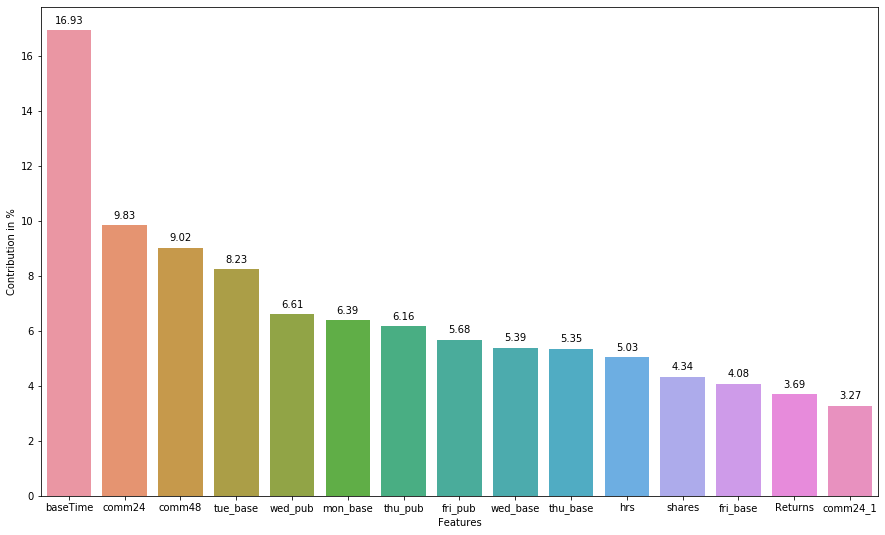

In [57]:
plt.subplots(figsize=(15,9))
act = sns.barplot(x="Features", y="Contribution", data=contribution, order=contribution.Features.tolist())
act.set(xlabel='Features', ylabel='Contribution in %')
for p in act.patches:
    act.annotate(round(p.get_height(),2), (p.get_x() + p.get_width() / 2, round(float(p.get_height()),2)), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.savefig(chartdir+'Contribution of Features.png')
plt.show()

### Comparing Actual vs Predicted

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=10)

In [59]:
Y_Pred_test = MLPreg.best_estimator_.predict(X_test)

In [60]:
actvspred=pd.DataFrame(data={'Actual':(np.exp(Y_test)-1).reshape(-1,),'Predicted':(np.exp(Y_Pred_test)-1).reshape(-1,)})
actvspred.head(20)


,Actual,Predicted
0,17.0,14.371835
1,11.0,5.792998
2,4.0,7.862453
3,0.0,1.147101
4,0.0,0.178964
5,1.0,0.890524
6,1.0,1.084473
7,0.0,-0.049155
8,0.0,0.144306
9,0.0,0.056271


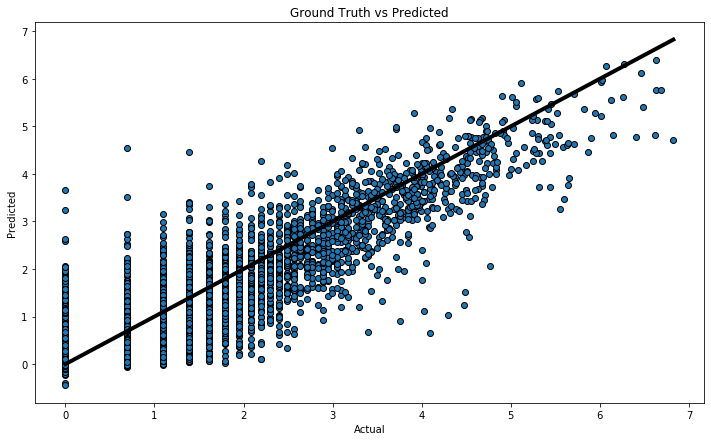

In [61]:
fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(Y_test, Y_Pred_test, edgecolors=(0, 0, 0))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k-', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.savefig(chartdir+'Actual vs Predicted.png')
plt.show()